양방향 LSTM을 이용한 품사 태깅

In [3]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 토큰화에 품사 태깅이 된 데이터 받기
tagged_sentences = nltk.corpus.treebank.tagged_sents()
print("품사 태깅이 된 문장 개수 :", len(tagges_sentences))

품사 태깅이 된 문장 개수 : 3914


In [8]:
# 단어와 품사끼리 따로 저장해주기
sentences, pos_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence) # zip으로 동일한 개수를 가지는 시퀀스 자료형에서 동일한 순서로 묶어줌
    sentences.append(list(sentence))
    pos_tags.append(list(tag_info))
    
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


샘플 최대 길이 : 271
샘플 평균 길이 : 25.722023505365357


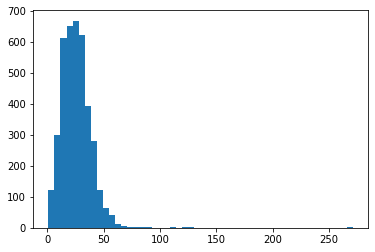

In [9]:
print("샘플 최대 길이 :", max(len(l) for l in sentences))
print("샘플 평균 길이 :", sum(map(len, sentences))/len(sentences))

plt.hist([len(l) for l in sentences], bins=50)
plt.show()


In [20]:
def tokenize(samples):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(samples)
    return tokenizer

In [21]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)
vocab_size = len(src_tokenizer.word_index)+1
tag_size = len(tar_tokenizer.word_index)+1

print("단어 집합 크기 : {}".format(vocab_size))
print("태깅 정보 집합 크기 : {}".format(tag_size))

단어 집합 크기 : 11388
태깅 정보 집합 크기 : 47


In [22]:
# 정수 인코딩
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [23]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [24]:
# 비율 분리
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150)


LSTM Model 구축
- 태깅은 다대다 문제
    - return_sequences = True
    - 양방향을 위해 LSTM 을 Bidirectional() 으로 묶어준다
- 손실에서 원-핫 인코딩을 하지 않았으면
    - sparse_categorical_crossentropy 를 적용해줄 것

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=7, validation_data=(X_test, y_test))

Epoch 1/7


2022-08-02 12:56:15.482862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 12:56:16.223889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 12:56:16.385097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 12:56:16.941540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 12:56:17.106466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 0.5925 - accuracy: 0.3174

2022-08-02 12:56:25.773740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 12:56:26.200057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 12:56:26.289757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 14s 404ms/step - loss: 0.5925 - accuracy: 0.3174 - val_loss: 0.3801 - val_accuracy: 0.5405
Epoch 2/7
25/25 [==============================] - 7s 297ms/step - loss: 0.2801 - accuracy: 0.6381 - val_loss: 0.2207 - val_accuracy: 0.7121
Epoch 3/7
25/25 [==============================] - 7s 296ms/step - loss: 0.1903 - accuracy: 0.7427 - val_loss: 0.1754 - val_accuracy: 0.7635
Epoch 4/7
25/25 [==============================] - 7s 299ms/step - loss: 0.1521 - accuracy: 0.7893 - val_loss: 0.1510 - val_accuracy: 0.8035
Epoch 5/7
25/25 [==============================] - 7s 297ms/step - loss: 0.1305 - accuracy: 0.8194 - val_loss: 0.1373 - val_accuracy: 0.8173
Epoch 6/7
25/25 [==============================] - 7s 296ms/step - loss: 0.1136 - accuracy: 0.8431 - val_loss: 0.1311 - val_accuracy: 0.8270
Epoch 7/7
25/25 [==============================] - 7s 299ms/step - loss: 0.0988 - accuracy: 0.8631 - val_loss: 0.1277 - val_accuracy: 0.8292


In [28]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 2s 57ms/step - loss: 0.1271 - accuracy: 0.8287

 테스트 정확도: 0.8287


In [29]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

i = 10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측값 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 레이블로 변환.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], y_test[i], y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_tag[tag].upper(), index_to_tag[pred].upper()))

2022-08-02 12:57:16.039566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 12:57:16.426830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-02 12:57:16.513654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


단어             |실제값  |예측값
-----------------------------------
since            : IN      IN
chalk            : NN      NNP
first            : RB      JJ
touched          : VBD     NNP
slate            : NN      NNS
,                : ,       ,
schoolchildren   : NN      NNS
have             : VBP     VBP
wanted           : VBN     VBN
*-1              : -NONE-  -NONE-
to               : TO      TO
know             : VB      VB
:                : :       :
what             : WP      WP
's               : VBZ     VBZ
*t*-2            : -NONE-  -NONE-
on               : IN      IN
the              : DT      DT
test             : NN      NN
?                : .       .
